In [1]:
# importing most of the libraries 
import numpy as np
import pandas as pd
import collections

import matplotlib
% matplotlib inline

from matplotlib import cm
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from collections import Counter

from sklearn.cluster import KMeans, DBSCAN

# Preprocess Data

In [58]:
power_path = "../../../data/testing/power.csv" # "power.csv"
df_in = pd.read_csv(power_path, index_col=[0], parse_dates=True, names=["dt", "power"])

pf_path = "../../../data/testing/power_factor.csv"
df_in["pf"] = pd.read_csv(pf_path, index_col=[0], parse_dates=True, names=["dt", "pf"])

pf_path = "../../../data/testing/mcu_temp.csv"
df_in["temp"] = pd.read_csv(pf_path, index_col=[0], parse_dates=True, names=["dt", "temp"])

In [59]:
df_in["theta"] = np.arccos(df_in["pf"])
df_in["active"] = np.cos(df_in["theta"]) * df_in["power"]
df_in["reactive"] = np.sin(df_in["theta"]) * df_in["power"]

df_in.head()

,power,pf,temp,theta,active,reactive
dt,,,,,,
2016-07-01 18:30:12,207,0.97,NaN,0.245565,200.790006,50.322694
2016-07-01 18:30:42,209,0.97,NaN,0.245565,202.730006,50.808903
2016-07-01 18:31:12,2235,0.89,NaN,0.473451,1989.149969,1019.071834
2016-07-01 18:31:42,2356,0.90,NaN,0.451027,2120.399943,1026.956708
2016-07-01 18:32:12,2335,0.90,NaN,0.451027,2101.499944,1017.803019


In [60]:
df_rs = df_in.resample('1T').mean().dropna()

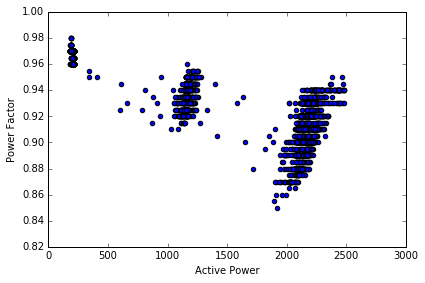

In [61]:
df_rs.plot(kind='scatter', x='active', y='pf')

plt.xlabel('Active Power')
plt.ylabel('Power Factor')

plt.tight_layout()
plt.savefig('../../../figures/raw/clusters.pdf')

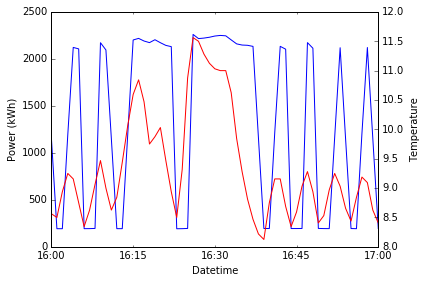

In [79]:
df_plot = df_rs.loc['2016-07-03'].between_time('16:00', '17:00')

fig, ax = plt.subplots()

df_plot["active"].plot(ax=ax)

ax2 = ax.twinx()
df_plot["temp"].plot(ax=ax2, color='red')

ax.set_xlabel('Datetime')
ax.set_ylabel('Power (kWh)')

ax2.set_ylabel('Temperature')

plt.tight_layout()
plt.savefig('../../../figures/raw/b2_sample_plot.pdf')

# Cluster States of Appliance

In [6]:
bindx = int(0.7 * df_rs.shape[0])

In [7]:
df_train = df_rs.ix[:bindx, ["pf", "active"]]

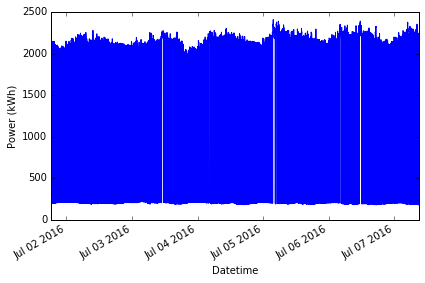

In [82]:
df_train["active"].plot()

plt.xlabel('Datetime')
plt.ylabel('Power (kWh)')

plt.tight_layout()
plt.savefig('../../../figures/raw/b2_power.pdf')

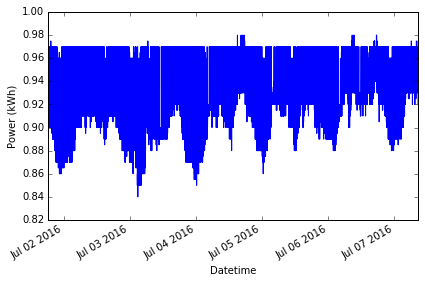

In [83]:
df_train["pf"].plot()

plt.xlabel('Datetime')
plt.ylabel('Power (kWh)')

plt.tight_layout()
plt.savefig('../../../figures/raw/b2_pf.pdf')

In [8]:
print len(df_rs), bindx

11512 8058


In [9]:
df_train.head()

,pf,active
dt,,
2016-07-01 18:30:00,0.970,201.760006
2016-07-01 18:31:00,0.895,2054.774956
2016-07-01 18:32:00,0.900,2094.299944
2016-07-01 18:33:00,0.935,1141.244975
2016-07-01 18:34:00,0.970,200.790006


In [10]:
db = DBSCAN(eps=50, min_samples=10)
db.fit(df_train)

DBSCAN(algorithm='auto', eps=50, leaf_size=30, metric='euclidean',
    min_samples=10, n_jobs=1, p=None)

In [11]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [12]:
df_train["labels"] = labels
df_train.head()

,pf,active,labels
dt,,,
2016-07-01 18:30:00,0.970,201.760006,0
2016-07-01 18:31:00,0.895,2054.774956,1
2016-07-01 18:32:00,0.900,2094.299944,1
2016-07-01 18:33:00,0.935,1141.244975,2
2016-07-01 18:34:00,0.970,200.790006,0


In [13]:
df_t1 = df_train[df_train["labels"] != -1]

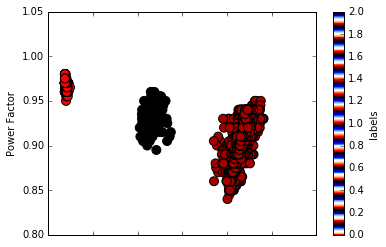

In [14]:
df_t1.plot(kind='scatter', x='active', y='pf', c='labels', colormap='flag', s=80)

plt.xlabel('Active Power')
plt.ylabel('Power Factor')

In [15]:
df_train.head()

,pf,active,labels
dt,,,
2016-07-01 18:30:00,0.970,201.760006,0
2016-07-01 18:31:00,0.895,2054.774956,1
2016-07-01 18:32:00,0.900,2094.299944,1
2016-07-01 18:33:00,0.935,1141.244975,2
2016-07-01 18:34:00,0.970,200.790006,0


In [16]:
df_train.groupby("labels").mean()

,pf,active
labels,,
-1,0.924571,1089.954428
0,0.968630,201.848182
1,0.905193,2163.297855
2,0.934581,1169.429482


# Learn Substates

In [17]:
df_train["labels"].head()

dt
2016-07-01 18:30:00    0
2016-07-01 18:31:00    1
2016-07-01 18:32:00    1
2016-07-01 18:33:00    2
2016-07-01 18:34:00    0
Name: labels, dtype: int64

In [18]:
# Step 2, creating sub states based on the time intervals
def addtime(df_labels):
    num = 0
    count = 0
    prev_label = -2

    df_out = pd.DataFrame()
    for i in range(df_labels.shape[0]):
        if i == 0:
            num += 1
        elif df_labels.ix[i] == df_labels.ix[i-1]:
            num+= 1
        else:
            df_out.loc[count, "label"] = df_labels.ix[i-1]
            df_out.loc[count, "count"] = num
            num = 1
            count += 1
            
    return df_out

In [19]:
sub_states = addtime(df_train["labels"])

In [20]:
sub_states.head()

,label,count
0,0.0,1.0
1,1.0,2.0
2,2.0,1.0
3,0.0,2.0
4,2.0,1.0


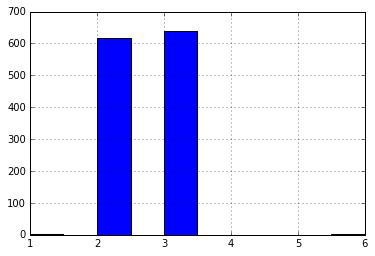

In [21]:
# Standby State
sub_states[sub_states["label"] == 0]["count"].hist()

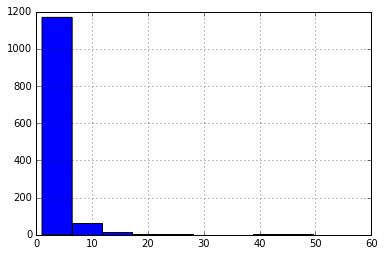

In [22]:
# Compressor Off State
sub_states[sub_states["label"] == 1]["count"].hist()

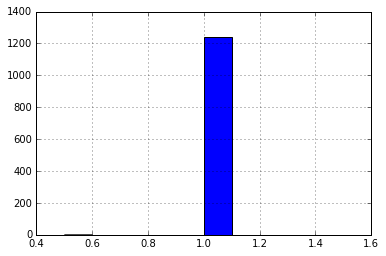

In [23]:
# Compressor On State
sub_states[sub_states["label"] == 2]["count"].hist()

# Learn Periodicity

In [24]:
df_labels = df_train["labels"].reset_index(drop=True)

In [25]:
periodicity = dict()

In [26]:
labels = np.delete(df_train["labels"].unique(), -1)
df_s3 = pd.DataFrame(index=labels, columns=["mean", "std", "min", "max"])
for label in labels:
    periodicity[label] = np.ediff1d(df_labels[df_labels==label].index.values) - 1
    df_s3.loc[label, "mean"] = np.mean(periodicity[label])
    df_s3.loc[label, "std"] = np.std(periodicity[label])
    df_s3.loc[label, "min"] = min(periodicity[label])
    df_s3.loc[label, "max"] = max(periodicity[label])

In [27]:
periodicity

{0: array([3, 0, 3, ..., 0, 3, 0]),
 1: array([0, 4, 4, ..., 3, 0, 0]),
 2: array([2, 1, 2, ..., 2, 2, 2])}

In [28]:
df_s3

,mean,std,min,max
0,1.55049,3.12399,0,56
1,1.22486,1.70593,0,7
2,5.47703,8.87588,1,105


# Learn Transition Matrix

In [29]:
n_labels_ = len(labels)
print n_labels_

3


In [30]:
tm = np.zeros((n_labels_, n_labels_), dtype=float)
tm

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [31]:
l_vals = df_train[df_train["labels"] != -1]["labels"].values

trans_count = Counter(zip(l_vals, l_vals[1:]))
trans_count

Counter({(0, 0): 1901,
         (0, 1): 630,
         (0, 2): 628,
         (1, 0): 644,
         (1, 1): 2363,
         (1, 2): 614,
         (2, 0): 614,
         (2, 1): 628})

In [32]:
for (x,y), c in trans_count.iteritems():
    tm[x,y] = c  

tm.astype(int)

array([[1901,  630,  628],
       [ 644, 2363,  614],
       [ 614,  628,    0]])

In [33]:
for i in range(n_labels_):
    tm[i,:] = tm[i,:] / np.sum(tm[i, :])

In [34]:
tm

array([[ 0.60177271,  0.1994302 ,  0.19879709],
       [ 0.17785142,  0.65258216,  0.16956642],
       [ 0.49436393,  0.50563607,  0.        ]])

# Testing

In [36]:
df_test = df_rs.ix[bindx:, ["pf", "active"]]
df_test.head()

,pf,active
dt,,
2016-07-07 08:56:00,0.97,184.300006
2016-07-07 08:57:00,0.94,2210.879995
2016-07-07 08:58:00,0.94,2242.839995
2016-07-07 08:59:00,0.94,2226.859995
2016-07-07 09:00:00,0.97,184.785006


In [38]:
df_out = df_test.copy()

In [40]:
df_out["labels"] = db.fit_predict(df_test)
df_out.head()

,pf,active,labels
dt,,,
2016-07-07 08:56:00,0.97,184.300006,0
2016-07-07 08:57:00,0.94,2210.879995,1
2016-07-07 08:58:00,0.94,2242.839995,1
2016-07-07 08:59:00,0.94,2226.859995,1
2016-07-07 09:00:00,0.97,184.785006,0


In [41]:
df_out[df_out["labels"] == -1]

,pf,active,labels
dt,,,
2016-07-07 09:17:00,0.945,1395.549994,-1
2016-07-07 11:16:00,0.930,658.709983,-1
2016-07-07 14:31:00,0.925,1508.445016,-1
2016-07-07 15:11:00,0.955,364.415002,-1
2016-07-07 18:56:00,0.910,1683.820004,-1
2016-07-08 07:30:00,0.875,1494.775003,-1
2016-07-08 08:05:00,0.935,636.799989,-1
2016-07-08 14:37:00,0.900,1651.860022,-1
2016-07-08 15:24:00,0.945,610.510012,-1


In [ ]:
from sklearn.cluster import KMeans, DBSCAN
# If DBSCAN returns -1 then it is not part of any cluster and it is an anomaly 
def checkstep1(data):
    anomaly_array = []
    step1_output = []
    test_labels_kmeans = kmeans.predict(data)
    db.fit(test)
    test_labels_dbscan = db.labels_
    for i in range(len(test_labels_kmeans)):
        
        if test_labels_dbscan[i] == -1:
            anomaly_array.append(-1)
            step1_output.append("Malfunction")
        else:
            anomaly_array.append(test_labels_kmeans[i])
            step1_output.append("Step 1 Cleared")
            
    return anomaly_array, step1_output

In [ ]:
anomaly, s1_output = checkstep1(test)

In [ ]:
def checkstep2(enter_input):
    checkstep2_output = []
    test_labels_kmeans = kmeans.predict(enter_input)
    test_labels_kmeans = list(test_labels_kmeans)
    new_sub_states = addtime(test_labels_kmeans)
    #print(test_labels_kmeans)
    for i in range(len(test_labels_kmeans)):
        if test_labels_kmeans[i] == 1:
            
            if new_sub_states[i] in best_ones:
                checkstep2_output.append("Step2 Cleared")
                #print(test_labels_kmeans[i])
                #print(new_sub_states[i])
            else:
                checkstep2_output.append("Step2_malfunction")
        else:
            if new_sub_states[i] in best_zero:
                checkstep2_output.append("Step2 Cleared")
            else:
                checkstep2_output.append("Step2_malfunction")
        
    return checkstep2_output

In [ ]:
step2 = checkstep2(test)

In [ ]:
def checkstep3(enter_input, tolerance):
    test_labels_kmeans = kmeans.predict(enter_input)
    test_labels_kmeans = list(test_labels_kmeans)
    new_sub_states = addtime(test_labels_kmeans)
    info_list = []
    info_list.append(np.mean(enter_input))
    info_list.append(max(enter_input))
    info_list.append(min(enter_input))
    info_list.append(np.std(enter_input))
    
    if np.std(info_list) > np.std(step3)*(1 + tolerance) :
        return "Step 3 problem, Greater"
    elif np.std(info_list) < np.std(step3)* (1 - tolerance):
        return "Step 3 problem, Lower"
    else:
        return "No Problem"

In [ ]:
# as we want 2 sigma tolerance
checkstep3(test, 0.66)

In [ ]:
def checkstep4(enter_input, tolerance):
    
    test_labels_kmeans = kmeans.predict(enter_input)
    test_labels_kmeans = list(test_labels_kmeans)
    Bmat =  checkfreq(test_labels_kmeans)
    print(np.std(Bmat))
    print(np.std(Amat))
    
    if np.std(Bmat) > np.std(Amat)*(1 + tolerance) :
        return "Step 4 problem, Greater"
    elif np.std(Bmat) < np.std(Amat)* (1 - tolerance):
        return "Step 4 problem, Lower"
    else:
        return "No Problem"

In [ ]:
checkstep4(test,0.5)

In [ ]:
full_output = pd.DataFrame(data = [s1_output, step2])

In [ ]:
#this is how the output will look like
# Step 3 and 4 will just be one line reporting if the whole data passed the step or not
full_output = full_output.T
full_output.columns = ["Step1", "Step2"]
full_output.head()

# Unused Code

In [ ]:
#now lets divide the data
ones = df[df['labels'] == 1]
zeros = df[df['labels'] == 0]

In [ ]:
# Choosing the best sub states by elimiating one that are not useful
def best_sub_states(dat):
    
    a = dat.substates.values
    counttype=collections.Counter(a)
    print("How the Distribution looks like")
    print("**"*40)
    print(counttype)
    print("Visualising")
    print("**"*40)
    keytype = list(counttype.keys())
    populationtype = list(counttype.values())

    dataa = [go.Bar(
                y= populationtype,
                x = keytype,
                width = 1.5,
                marker=dict(
                   color = populationtype,
                colorscale='Portland',
                showscale=True,
                reversescale = False
                ),
                opacity=0.6
            )]
    
    layout= go.Layout(
        autosize= True,
        title= 'Distribution of Sub_States',
        hovermode= 'closest',
        yaxis=dict(
            title= 'Number of repetitions',
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=dataa, layout=layout)
    py.iplot(fig, filename='barplottype')
    
    best_sub = []
    for i in range(len(populationtype)):
        if populationtype[i] > 20:
            best_sub.append(keytype[i])
    
    return best_sub

In [ ]:
best_ones = best_sub_states(ones)

In [ ]:
best_zero = best_sub_states(zeros)